# Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')

In [1]:
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore');

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [4]:
from src.metric_functions import get_metrics_classification, get_metrics_multiclass, check_overfitting_classification, check_overfitting_multiclass

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('darkgrid')

# Описание задачи

**В данном jupyter-ноутбуке мы обучим бейзлайн модели на данных, которые мы аггрегировали в Data_preprocession.ipnb**

## О соревновании и данных

https://ods.ai/competitions/mtsmlcup

Задача соревнования
- Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

Метрики соревнования:
* ROC-AUC – для определения пола, f1 weighted – для определения возраста.
* Все решения рассчитываются по формуле -  2 * f1_weighted(по 6 возрастным бакетам) + gini по полу.
* Возрастные бакеты (Класс 1 — 19-25, Класс 2 — 26-35, Класс 3 — 36-45, Класс 4 — 46-55, Класс 5 — 56-65, Класс 6 — 66+).

Предобработка, аггрегация и создание новых фич произведена в 0.Data_preparing.ipng.
Описание колонок аггрегированного файла с данными:
* 'part_of_day_day' – кол-во визитов пользователя днем
* 'part_of_day_evening' – кол-во визитов пользователя вечером
* 'part_of_day_morning' – кол-во визитов пользователя утром
* 'part_of_day_night' – кол-во визитов пользователя ночью
* 'sum_visits' – кол-во визитов пользователя
* 'day_pct' – доля визитов пользователя днем
* 'evening_pct' – доля визитов пользователя вечером
* 'morning_pct' – доля визитов пользователя утром
* 'night_pct' – доля визитов пользователя ночью
* 'act_days' – кол-во дней, в которые пользователь совершил визит пользователя
* 'request_cnt' - кол-во запросов пользователя
* 'avg_req_per_day' - среднее кол-во запросов пользователя
* 'period_days' - кол-во дней между первым и последним визитом пользователя
* 'request_std' - стандартное отклонение по количеству запросов
* 'act_days_pct' - доля дней, когда пользователь совершал визит
* 'cpe_type_cd - тип устройства
* 'cpe_model_os_type' - операционная система устройства
* 'cpe_manufacturer_name' -производитель устройства
* 'price' - цена устройства пользователя
* 'region_cnt' - кол-во уникальных регионов, из которых был совершен визит
* 'city_cnt' - кол-во уникальных городов, из которых был совершен визит
* 'url_host_cnt' - кол-во уникальных ссылок, с которых был совершен визит
* 'user_id' – ID пользователя

Описание колонок файла с таргетами:

* 'age' – Возраст пользователя
* 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)
* 'user_id' – ID пользователя

## Структура проекта

Данная работа была разделена на несколько jupyter ноутбуков:

0. Data_preparing.ipnb - аггрегация отдельных файлов по user_id и склейка в финальный датасет
1. EDA.ipynb - исследовательская часть
2. baseline.ipynb - бейзлайн модели
3. create_embeddings.ipynb - создание эмбеддингов для дальнейшего их использования в качестве фич
4. baseline_embeddings.ipynb - бейзлан модели с эмбеддингами
5. model_tuning.ipynb - тюнинг наиболее перспективных моделей
6. gender_prediction_stacking.ipynb - стекинг моделей для предсказания пола

In [6]:
RAND = 42

# типы данных для экономии памяти
final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Сбор всех данных

In [7]:
# id пользователей, которым нужно предсказать пол и возраст
id_to_submit = pd.read_parquet('submit.pqt')

# таргеты для обучения моделей
targets = pd.read_parquet('public_train.pqt')

# предобработанные нами данные
df = pd.read_csv('data_agg/df_final.csv')

In [8]:
# поменяем тип данных, чтобы сэкономить память
df = df.astype(final_types)

In [8]:
df.head()

,user_id,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,morning_pct,night_pct,...,period_days,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,13,467,447,411,226,1551,0.301096,0.288201,0.264990,0.145712,...,116,1.618662,0.974138,smartphone,Android,BQ Devices Limited,-999.0,1,1,83
1,41,7,13,9,9,38,0.184211,0.342105,0.236842,0.236842,...,4,1.562360,1.000000,smartphone,Android,Xiaomi,12343.0,1,3,15
2,69,457,346,314,30,1147,0.398431,0.301656,0.273758,0.026155,...,60,1.331956,0.933333,smartphone,iOS,Apple,16657.0,1,1,91
3,71,49,57,12,7,125,0.392000,0.456000,0.096000,0.056000,...,8,0.865094,1.000000,smartphone,iOS,Apple,38037.0,2,2,35
4,85,838,1067,602,333,2840,0.295070,0.375704,0.211972,0.117254,...,41,1.144101,0.926829,smartphone,iOS,Apple,55809.0,2,6,174


In [9]:
# получаем итоговый датасет для обучения моделей
df_train = targets.merge(df, how='inner', on=['user_id'])
df_train.head()

,age,is_male,user_id,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,...,period_days,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,31.0,1,350459,84,27,67,0,178,0.471910,0.151685,...,32,0.745626,0.875000,smartphone,Android,Xiaomi,14948.0,1,1,36
1,35.0,1,188276,33,41,27,10,111,0.297297,0.369369,...,17,0.719450,0.823529,smartphone,Android,Samsung,11434.0,1,1,21
2,41.0,0,99002,310,198,116,15,639,0.485133,0.309859,...,53,0.729268,0.905660,smartphone,Android,Huawei,18288.0,1,3,121
3,33.0,0,155506,6,0,16,0,22,0.272727,0.000000,...,2,1.162174,1.000000,smartphone,iOS,Apple,37090.0,1,1,19
4,54.0,0,213873,0,0,4,0,4,0.000000,0.000000,...,1,0.000000,1.000000,smartphone,Android,Huawei,8987.0,1,1,4


In [10]:
# удаляем пропущенные значения
df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()

df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

# Baseline gender prediction

In [12]:
# сплит данных на train/validation/test
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

## LGBM

In [ ]:
# обучение бейзлайна LightGBM
%%time
lgbm_gender = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train_,
                y_train_,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=False)

CPU times: user 5.01 s, sys: 7.67 ms, total: 5.02 s
Wall time: 1.35 s


LGBMClassifier(random_state=42, scale_pos_weight=0.9531740695036613)

In [ ]:
# итоговый балл соревнования считается по GINI по полу
# проверим какой GINI мы получили
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.257


In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.652
ROC-AUC test = 0.629
delta = 3.67%


In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)

metrics_gender = get_metrics_classification(y_test,
                                            y_pred_test,
                                            y_score_test,
                                            name='LGBMBaseline')
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.58562,0.628592,0.257185


## CatBoost

In [ ]:
# обучение бейзлайна CatBoost
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(allow_writing_files=False,
                                random_state=RAND,
                                eval_metric="AUC",
                                cat_features=cat_features,
                                scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 1min 31s, sys: 2.78 s, total: 1min 34s
Wall time: 28.1 s


In [ ]:
# получим оценку GINI
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.260


In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.653
ROC-AUC test = 0.630
delta = 3.57%


In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoostBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068


## XGBoost

In [ ]:
# сплит данных на train/validation/test с one hot encoding
%%time
X = pd.get_dummies(df_train.drop(['user_id', 'age', 'is_male'], axis=1))
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 264 ms, sys: 3.89 ms, total: 268 ms
Wall time: 267 ms


In [ ]:
# обучение бейзлайна XGBoost
%%time
xgb_gender = XGBClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

xgb_gender.fit(X_train_,
               y_train_,
               eval_metric='auc',
               eval_set=eval_set,
               early_stopping_rounds=100,
               verbose=0)

CPU times: user 1min 21s, sys: 84.5 ms, total: 1min 21s
Wall time: 21.9 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
# получим оценку GINI
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, xgb_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.247


In [ ]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(xgb_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.678
ROC-AUC test = 0.623
delta = 8.81%


In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = xgb_gender.predict(X_test)
y_score_test = xgb_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='XGBoostBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
0,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683


## RandomForest

In [ ]:
# обучение бейзлайна RandomForest
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=RAND)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# получим итоговые метрики на тестовых данных
y_pred_test = clf_rf.predict(X_test)
y_score_test = clf_rf.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='RandomForestBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
0,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
0,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970


Вывод: лучше всего себя показал бейзлайн catboost

In [ ]:
# сохраним метрики, чтобы в дальнейшем сравнивать их с моделями на тюнинге
metrics_gender.to_csv('./metrics/metrics_gender_baseline.csv', index=False)

# Baseline age prediction

In [11]:
def age_bucket(x):
    """Функция для создания бакетов по возрасту"""
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

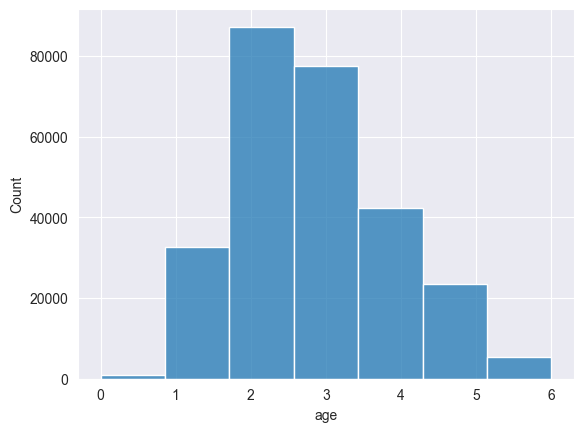

In [12]:
df_trn = targets.merge(df, how='inner', on=['user_id'])

# удаляем пропущенные значения
df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()

# создаем бакеты по возрасту
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7);

In [13]:
# по условиям соревнования в тестовых данных нет людей младше 19 лет
# поэтому можем удалить бакет 0
df_trn = df_trn.query('age > 0')

In [14]:
# разбивка данных на train/validation/test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

## LGBM

In [15]:
# обучение бейзлайна LightGBM
lgbm_age = LGBMClassifier(random_state=RAND,
                          class_weight='balanced',
                          objective='multiclass')
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

LGBMClassifier(class_weight='balanced', objective='multiclass', random_state=42)

In [16]:
# проверим модель на переобучение
check_overfitting_multiclass(lgbm_age, X_train, y_train, X_test, y_test)

f1-weighted train = 0.308
f1-weighted test = 0.246
delta = 25.19%


In [17]:
print(
    m.classification_report(
        y_test,
        lgbm_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.26      0.54      0.35      6528
       26-35       0.40      0.20      0.27     17454
       36-45       0.35      0.19      0.24     15497
       46-55       0.22      0.15      0.18      8489
       56-65       0.15      0.23      0.18      4716
         66+       0.05      0.44      0.09      1101

    accuracy                           0.24     53785
   macro avg       0.24      0.29      0.22     53785
weighted avg       0.31      0.24      0.25     53785



In [18]:
# получим итоговые метрики на тестовых данных
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)

metrics_age = get_metrics_multiclass(y_test_bin=y_test_bin,
                                     y_test=y_test,
                                     y_pred=y_pred,
                                     y_prob=y_score,
                                     name='LGBM_Baseline',
                                     type_multi='ovo')
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.23725,0.239119,0.292757,0.239119,0.218909,0.246096,1.66058


## Catboost

In [19]:
# обучение бейзлайна CatBoost
cat_features = X.select_dtypes('category').columns.tolist()
cat_age = CatBoostClassifier(allow_writing_files=False,
                             cat_features=cat_features,
                             random_state=RAND)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

In [20]:
# проверим модель на переобучение
check_overfitting_multiclass(cat_age, X_train, y_train, X_test, y_test)

f1-weighted train = 0.376
f1-weighted test = 0.321
delta = 16.93%


In [21]:
print(
    m.classification_report(
        y_test,
        cat_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.41      0.12      0.19      6528
       26-35       0.40      0.60      0.48     17454
       36-45       0.33      0.47      0.39     15497
       46-55       0.31      0.09      0.14      8489
       56-65       0.30      0.06      0.10      4716
         66+       0.18      0.00      0.00      1101

    accuracy                           0.37     53785
   macro avg       0.32      0.22      0.22     53785
weighted avg       0.35      0.37      0.32     53785



In [22]:
# получим итоговые метрики на тестовых данных
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Baseline',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
0,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261


## RandomForest

In [23]:
# разбивка данных на train/validation/test
X = pd.get_dummies(df_trn.drop(['age', 'is_male', 'user_id'], axis=1))
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

In [24]:
# обучение бейзлайна RandomForest
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=RAND)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
print(
    m.classification_report(
        y_test,
        clf_rf.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.37      0.12      0.19      6528
       26-35       0.38      0.59      0.46     17454
       36-45       0.33      0.44      0.38     15497
       46-55       0.25      0.08      0.12      8489
       56-65       0.22      0.04      0.06      4716
         66+       0.03      0.00      0.00      1101

    accuracy                           0.35     53785
   macro avg       0.26      0.21      0.20     53785
weighted avg       0.32      0.35      0.30     53785



In [26]:
# получим итоговые метрики на тестовых данных
y_pred = clf_rf.predict(X_test)
y_score = clf_rf.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='RandomForest_Baseline',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
0,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261
0,RandomForest_Baseline,0.634683,0.347439,0.262835,0.347439,0.211312,0.347439,0.201186,0.303809,1.712283


Вывод: в предсказнии возраста Catboost переобучился, но показал лучшие результаты

In [27]:
# сохраним метрики, чтобы в дальнейшем сравнивать их с моделями на тюнинге
metrics_age.to_csv('./metrics/metrics_age_baseline.csv', index=False)